# Gaia CVs Poster for EAS meeting


In [11]:
# Imports
import pyvo.dal 
from pyvo.auth import authsession, securitymethods
import requests
import getpass
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table, Column, vstack, join
from astroquery.gaia import Gaia
from astroquery.xmatch import XMatch
import astropy.units as u

from gaiaxpy import convert

# To avoid warnings
import warnings
warnings.simplefilter("ignore")

## Get CVs

In [2]:
from astroquery.simbad import Simbad
query = '''SELECT main_id AS "id", ra, dec,  otype
FROM basic
where otype = 'CV*' '''
simbad_cvs = Simbad.query_tap(query)

In [3]:
print(simbad_cvs)

              id                      ra                 dec         otype
                                     deg                 deg              
----------------------------- ------------------ ------------------- -----
                    V* IX Dra    273.13112984158      67.07939492627   CV*
                   AT 2018fpd 320.77304166666664   15.14680555555555   CV*
                   AT 2018fpk 290.42116666666664 -10.363416666666664   CV*
                   AT 2018cex 219.41333333333336  -9.219330555555555   CV*
                   AT 2017cam  252.9826916666667 -16.351533333333336   CV*
                   AT 2020tjb 306.44252916666665   8.426977777777777   CV*
                ASASSN -19ady 105.96616666666667   32.89883333333333   CV*
MASTER OT J024902.25-082917.6  42.25937499999999  -8.488222222222221   CV*
                   AT 2019lvs         326.395431            20.69059   CV*
                          ...                ...                 ...   ...
   LAMOST J072304.77+0204

In [4]:


simbad_cvs_gaia = XMatch.query(
    cat1=simbad_cvs,
    cat2="vizier:I/355/gaiadr3",    # Gaia DR3; switch to I/345/gaiaedr3 for EDR3
    max_distance=1.0 * u.arcsec,    # must be a Quantity
    colRA1="ra", colDec1="dec"      # *only* for your table
)

print(simbad_cvs_gaia)

angDist              id             ... e_DEJ2000 RADEcorJ2000
 arcsec                             ...                       
-------- -------------------------- ... --------- ------------
0.245288                  V* IX Dra ...  0.762304       -0.078
0.368161                 AT 2017fmr ...  3.882432      -0.2652
0.073444                 PSST 17eeh ... 61.980637       0.8595
0.007379      SRGE J075818.3-612027 ...  16.87684      -0.3439
0.240997                   PB  7296 ...  4.157934       0.4085
0.286688    2MASS J22550417-3449179 ...  0.894619       0.3062
0.096048            OGLE BLG-DN-985 ...  5.657669       0.4447
0.028632           OGLE BLG-DN-1040 ...  8.881661       0.9953
0.189746                  AT 2017lu ... 70.982155      -0.0032
     ...                        ... ...       ...          ...
0.027399 LAMOST J065737.99+222348.2 ...  0.576199      -0.1089
0.086423 LAMOST J072304.77+020437.4 ...  0.493997      -0.1401
0.243484                PG 0818+513 ...  0.411939      

(array([213., 121., 165., 181., 214., 177., 155., 137., 127.,  98., 102.,
         84.,  76.,  67.,  62.,  57.,  62.,  40.,  39.,  40.,  42.,  36.,
         27.,  30.,  31.,  31.,  27.,  31.,  26.,  26.,  21.,  19.,  16.,
         13.,  21.,  27.,  23.,  19.,  18.,   9.,  13.,  21.,  24.,  25.,
         15.,  11.,  22.,  17.,  22.,  16.]),
 array([0.        , 0.01997752, 0.03995504, 0.05993256, 0.07991008,
        0.0998876 , 0.11986512, 0.13984264, 0.15982016, 0.17979768,
        0.1997752 , 0.21975272, 0.23973024, 0.25970776, 0.27968528,
        0.2996628 , 0.31964032, 0.33961784, 0.35959536, 0.37957288,
        0.3995504 , 0.41952792, 0.43950544, 0.45948296, 0.47946048,
        0.499438  , 0.51941552, 0.53939304, 0.55937056, 0.57934808,
        0.5993256 , 0.61930312, 0.63928064, 0.65925816, 0.67923568,
        0.6992132 , 0.71919072, 0.73916824, 0.75914576, 0.77912328,
        0.7991008 , 0.81907832, 0.83905584, 0.85903336, 0.87901088,
        0.8989884 , 0.91896592, 0.93894344, 0.

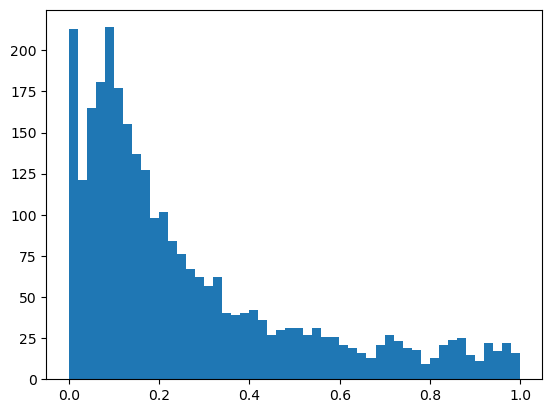

In [5]:
plt.hist(simbad_cvs_gaia['angDist'], bins=50)

In [6]:
print(simbad_cvs_gaia.info())
print(simbad_cvs_gaia['Source'])

retrieval_type = 'XP_CONTINUOUS'
data_structure = 'RAW'
data_release = 'Gaia DR3'
simbad_cvs_gaia_datadict = Gaia.load_data(simbad_cvs_gaia['Source'],data_release = data_release, retrieval_type=retrieval_type, data_structure=data_structure,format='fits')  


<Table length=2896>
     name      dtype      unit                   description               n_bad
------------- ------- ------------ --------------------------------------- -----
      angDist float64       arcsec           Xmatch distance in arcseconds     0
           id   str34                                                          0
           ra float64                                                          0
          dec float64                                                          0
        otype    str3                                                          0
      DR3Name   str28                                                          0
        RAdeg float64          deg                                             0
        DEdeg float64          deg                                             0
   errHalfMaj float32       arcsec Half Major axis of the positional error     0
   errHalfMin float32       arcsec Half Minor axis of the positional error     0
    errP

In [7]:
simbad_cvs_gaia_XPcoefficients = simbad_cvs_gaia_datadict['XP_CONTINUOUS_RAW.fits'][0] 

In [8]:
combined = [
    np.concatenate((row['bp_coefficients'], row['rp_coefficients']))
    for row in simbad_cvs_gaia_XPcoefficients
]

# Add it as a new column:
simbad_cvs_gaia_XPcoefficients['xp_coefficients'] = Column(combined, dtype=object)

In [9]:
normalized = []
for arr in simbad_cvs_gaia_XPcoefficients['xp_coefficients']:
    mn, mx = arr.min(), arr.max()
    if mx > mn:
        normed = (arr - mn) / (mx - mn)
    else:
        # if all values are identical, just map them to zero
        normed = np.zeros_like(arr)
    normalized.append(normed)

# add as a new column (or overwrite the old one if you prefer)
simbad_cvs_gaia_XPcoefficients['xp_coefficients_normalized'] = Column(normalized, dtype=object)

In [12]:
#print(simbad_cvs_gaia.columns)
#print(simbad_cvs_gaia_XPcoefficients.columns)
simbad_cvs_gaia_all  = join(simbad_cvs_gaia['Source','ra','dec','Plx','e_Plx','Gmag','BPmag','RPmag'],simbad_cvs_gaia_XPcoefficients['source_id','xp_coefficients','xp_coefficients_normalized'], keys_left=['Source'], keys_right=['source_id'])

In [13]:
simbad_cvs_gaia_all.colnames

['Source',
 'ra',
 'dec',
 'Plx',
 'e_Plx',
 'Gmag',
 'BPmag',
 'RPmag',
 'source_id',
 'xp_coefficients',
 'xp_coefficients_normalized']

In [ ]:
simbad_cvs_gaia_all['is_cv'] = 1

## Gaia DR3 with spectra

In [15]:
# query Gaia DR3 for objects with contiuous spectra, light curves, and parallax error less than 20%
def query_gaia_dr3():
    # Define the query

    query = """
    SELECT TOP 10000 source_id, ra, dec, parallax, parallax_error, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag
    FROM gaiadr3.gaia_source
    WHERE phot_g_mean_mag < 20 AND abs(parallax_error / parallax) < 0.2 and has_xp_continuous = 'True' and has_epoch_photometry = 'True'
    """

    # Execute the query
    result = pyvo.dal.TAPService("https://gea.esac.esa.int/tap-server/tap").search(query=query)

    # Convert to a pandas DataFrame
    df = result.to_table()
    
    return df

In [16]:
## This is one of the most important steps in this notebook, so we should run it only once
gaia_df = query_gaia_dr3()

In [17]:
#print(gaia_df.head())
print(gaia_df)

     source_id              ra         ... phot_bp_mean_mag phot_rp_mean_mag
                           deg         ...       mag              mag       
------------------- ------------------ ... ---------------- ----------------
5937144197726039936 251.45836750025484 ...        14.547703          13.3683
5937201166158273536 250.59869812717022 ...        17.783865        16.273722
5937081422478068096 251.62816700983052 ...        16.195265        15.053592
5937112346245404672 251.21581714756772 ...        15.084415       13.9363985
5937144403884482560 251.45482958655518 ...        17.332195        15.774271
5937173742710206208  250.0523413435189 ...         17.32309        15.967802
5937144781841910784 251.49762536071668 ...        16.538244         15.06033
5937201681554430848 250.55641645990838 ...        16.773216         15.21251
5937112685458529152 251.23972923896414 ...        15.350504        14.118507
                ...                ... ...              ...              ...

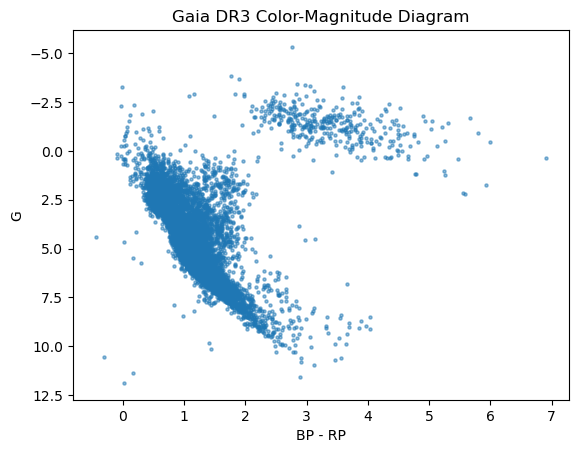

In [18]:
plt.scatter(gaia_df['phot_bp_mean_mag'] - gaia_df['phot_rp_mean_mag'], gaia_df['phot_g_mean_mag'] + 5 - 5 * np.log10(1000/gaia_df['parallax']), s=5, alpha=0.5)
plt.xlabel('BP - RP')
plt.ylabel('G')
plt.title('Gaia DR3 Color-Magnitude Diagram')
plt.gca().invert_yaxis()

In [19]:

gaia_source_list = gaia_df['source_id']#.to_list()
print(gaia_source_list)

     source_id     
-------------------
5937144197726039936
5937201166158273536
5937081422478068096
5937112346245404672
5937144403884482560
5937173742710206208
5937144781841910784
5937201681554430848
5937112685458529152
5937082109672885760
                ...
6030075916922646272
5542569366090667520
5542727730124243584
4264967091230001792
5542569606608804352
5542221645541060864
6030097357403863936
5542221851699744256
4264836936526309888
5542913959909852800
Length = 10000 rows


In [20]:
# https://astroquery.readthedocs.io/en/latest/gaia/gaia.html

retrieval_type = 'XP_CONTINUOUS'
data_structure = 'RAW'
data_release = 'Gaia DR3'
if len(gaia_source_list) > 5000:
    print("Warning: More than 1000 sources, this may take a while to download.")
    m = 5000
    for i in range(0, len(gaia_source_list), m):
        print(i)
        #yield data[i : i + m]
        gaia_source_list_split = gaia_source_list[i : i + m]  # Limit to first 1000 sources for performance
        datalink = Gaia.load_data(gaia_source_list_split,data_release = data_release, retrieval_type=retrieval_type, data_structure=data_structure,format='fits')   
        if i == 0:
            tmp = ''
            #xp_continuous_raw = tmp
            tmp = datalink['XP_CONTINUOUS_RAW.fits'][0]
        else:
            tmp = vstack([tmp,datalink['XP_CONTINUOUS_RAW.fits'][0]])
else:
    datalink = Gaia.load_data(gaia_source_list,data_release = data_release, retrieval_type=retrieval_type, data_structure=data_structure,format='fits')  
    tmp = datalink['XP_CONTINUOUS_RAW.fits'][0] 

0
5000


In [21]:
combined = [
    np.concatenate((row['bp_coefficients'], row['rp_coefficients']))
    for row in tmp
]

# Add it as a new column:
tmp['xp_coefficients'] = Column(combined, dtype=object)


In [22]:
print(tmp['bp_coefficients'][0])
print(tmp['rp_coefficients'][0])
print(tmp['xp_coefficients'][0])

[ 2.77213162e+03 -1.54733095e+02 -7.80098624e+01  1.43731182e+01
 -1.61800656e+01  4.14170272e+00 -9.15694712e+00  6.74416464e+00
 -8.52691522e-02  4.63027481e+00  1.89006895e+00  4.23656545e+00
 -3.69593457e-01 -1.35048590e+00  5.66521719e-01 -1.50010771e+00
  3.65439135e+00  1.13371882e+00 -4.71087443e-01 -1.17803268e+00
 -9.55210503e-01  2.01943432e+00 -2.04492933e+00 -1.36339345e+00
 -2.12707022e-01  1.76557391e+00  8.40289050e-01  7.20913444e-01
  1.73235107e+00 -5.31515357e-01  1.73759063e-01 -1.21334293e+00
  1.22564068e-01 -5.47047385e-01 -5.52814818e-01  2.78541396e-02
 -8.49828221e-01 -1.08575456e+00  6.26816015e-01  3.81958304e-02
 -1.37723231e+00 -1.56968117e-03  3.99681675e-01  1.36780367e-01
  2.51941800e-01 -5.11036969e-01 -6.93312151e-01 -1.55700711e-01
  1.41389159e-01  7.16697256e-01  6.09707824e-02 -5.70406612e-02
 -1.09597135e-01  1.50624077e-01 -7.96170467e-02]
[ 3.44770102e+03 -3.06631327e+02 -1.24641521e+00  1.36604770e+01
  1.18415197e+01 -1.81523600e+01 -5.7838

In [23]:
normalized = []
for arr in tmp['xp_coefficients']:
    mn, mx = arr.min(), arr.max()
    if mx > mn:
        normed = (arr - mn) / (mx - mn)
    else:
        # if all values are identical, just map them to zero
        normed = np.zeros_like(arr)
    normalized.append(normed)

# add as a new column (or overwrite the old one if you prefer)
tmp['xp_coefficients_normalized'] = Column(normalized, dtype=object)


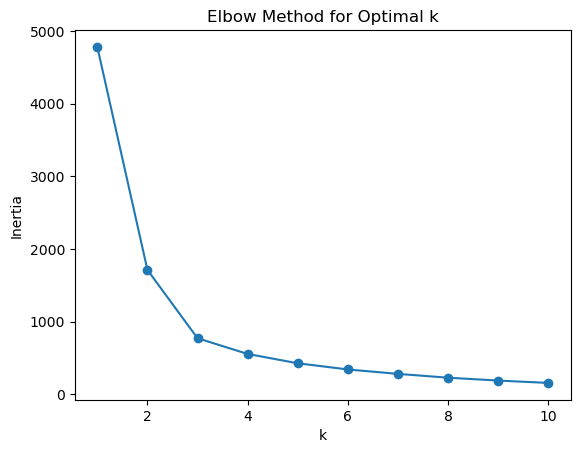

In [24]:
#import numpy as np
#from astropy.table import Table, Column
from sklearn.cluster import KMeans
#import matplotlib.pyplot as plt

# 1) Extract your normalized feature matrix
#    Shape will be (n_sources, 110)
features = np.vstack(tmp['xp_coefficients_normalized'])

# 2) (Optional) Choose k with an “elbow” plot
inertias = []
K = range(1, 11)
for k in K:
    km = KMeans(n_clusters=k, random_state=0)
    km.fit(features)
    inertias.append(km.inertia_)

plt.plot(K, inertias, 'o-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

# → pick k where the drop in inertia levels off

# 3) Run K-Means with your chosen k
k = 6  # or whatever you decide
km = KMeans(n_clusters=k, random_state=0)
labels = km.fit_predict(features)

# 4) Add the cluster labels back into your table
tmp['cluster'] = Column(labels, dtype=int)

# Now you can do e.g.:
# - tbl.group_by('cluster').groups to inspect each group
# - Plot average spectra per cluster, etc.


In [25]:
print(simbad_cvs_gaia_all.colnames)
print(gaia_df.colnames)
print(tmp.colnames)

joined = join(gaia_df, tmp['source_id','xp_coefficients', 'xp_coefficients_normalized','cluster'], keys='source_id')

#from astropy.table import Table, join
#
#print(gaia_df.info())
#tmp_pandas = Table.from_pandas(gaia_df)
#print(tmp_pandas.info)
#joined  = join(tmp_pandas,tmp, keys='source_id')

['Source', 'ra', 'dec', 'Plx', 'e_Plx', 'Gmag', 'BPmag', 'RPmag', 'source_id', 'xp_coefficients', 'xp_coefficients_normalized', 'is_cv']
['source_id', 'ra', 'dec', 'parallax', 'parallax_error', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']
['source_id', 'solution_id', 'bp_basis_function_id', 'bp_degrees_of_freedom', 'bp_n_parameters', 'bp_n_measurements', 'bp_n_rejected_measurements', 'bp_standard_deviation', 'bp_chi_squared', 'bp_coefficients', 'bp_coefficient_errors', 'bp_coefficient_correlations', 'bp_n_relevant_bases', 'bp_relative_shrinking', 'rp_basis_function_id', 'rp_degrees_of_freedom', 'rp_n_parameters', 'rp_n_measurements', 'rp_n_rejected_measurements', 'rp_standard_deviation', 'rp_chi_squared', 'rp_coefficients', 'rp_coefficient_errors', 'rp_coefficient_correlations', 'rp_n_relevant_bases', 'rp_relative_shrinking', 'xp_coefficients', 'xp_coefficients_normalized', 'cluster']


Clusters found: cluster
-------
      0
      1
      2
      3
      4
      5
Cluster 0
Cluster 1
Cluster 2
Cluster 3
Cluster 4
Cluster 5


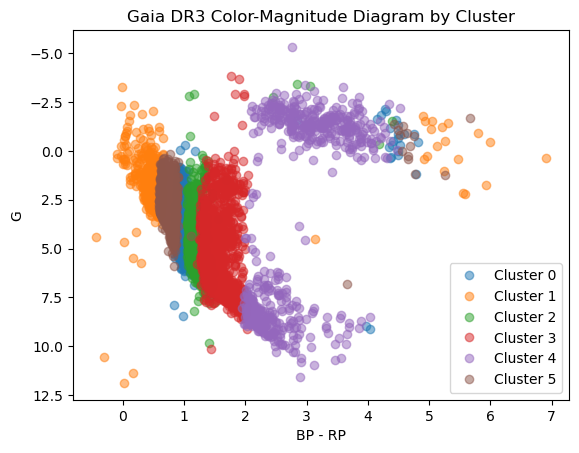

In [26]:
#joined.info()
clusters = np.unique(joined['cluster'])
print("Clusters found:", clusters)
for eachCluster in clusters:
    print("Cluster", eachCluster)
    cluster_data = joined[joined['cluster'] == eachCluster]
    #print(cluster_data)
    plt.plot(cluster_data['phot_bp_mean_mag'] - cluster_data['phot_rp_mean_mag'],
             cluster_data['phot_g_mean_mag'] + 5 - 5 * np.log10(1000/cluster_data['parallax']),
             'o', label=f'Cluster {eachCluster}', alpha=0.5)
plt.xlabel('BP - RP')
plt.ylabel('G')
plt.title('Gaia DR3 Color-Magnitude Diagram by Cluster')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


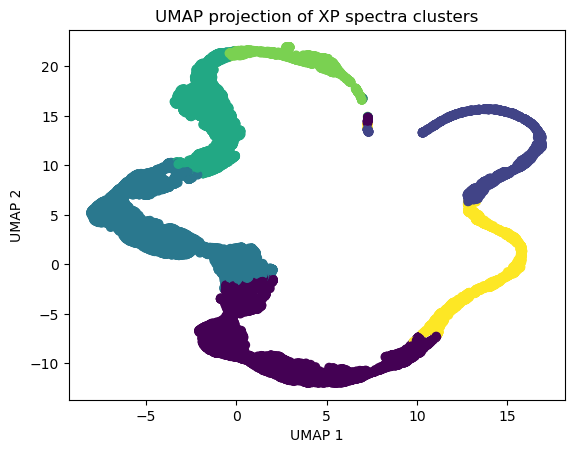

In [27]:
import umap

# 1) Prepare data
features = np.vstack(joined['xp_coefficients_normalized'])
labels   = np.array(joined['cluster'])

# 2) Run UMAP
reducer = umap.UMAP(n_components=2, random_state=42, min_dist=0.1)
embedding = reducer.fit_transform(features)

# 3) Plot
plt.figure()
plt.scatter(embedding[:,0], embedding[:,1], c=labels)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP projection of XP spectra clusters')
plt.show()

In [28]:
print(simbad_cvs_gaia_all.colnames)
print(joined.colnames)
joined.rename_columns(['parallax', 'parallax_error', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag'],['Plx', 'e_Plx', 'Gmag', 'BPmag', 'RPmag'])
#print(tmp_pandas.colnames)
#joined_2 = join(joined, simbad_cvs_gaia_all, keys_left='source_id', keys_right='Source', table_names=['gaia', 'simbad'],join_type='left')
#joined_2 = join(joined, simbad_cvs_gaia_all, keys_left='source_id', keys_right='Source',join_type='left')
#joined_2 = vstack([joined, simbad_cvs_gaia_all], join_type='outer', metadata_conflicts='silent')


['Source', 'ra', 'dec', 'Plx', 'e_Plx', 'Gmag', 'BPmag', 'RPmag', 'source_id', 'xp_coefficients', 'xp_coefficients_normalized', 'is_cv']
['source_id', 'ra', 'dec', 'parallax', 'parallax_error', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'xp_coefficients', 'xp_coefficients_normalized', 'cluster']


In [29]:
from astroquery.xmatch  import XMatch
get_available_tables = XMatch.get_available_tables()
print(get_available_tables)

['simbad', 'J/A+A/562/A79/table1', 'j/a+a/562/a79/table1', 'J/A+A/685/A1/goodss_b', 'j/a+a/685/a1/goodss_b', 'J/A+A/509/A17/tablea10', 'j/a+a/509/a17/tablea10', 'J/A+A/659/A144/tablec1', 'j/a+a/659/a144/tablec1', 'J/A+A/633/A7/list', 'j/a+a/633/a7/list', 'J/AJ/138/312/table1', 'j/aj/138/312/table1', 'J/A+A/632/A101/list', 'j/a+a/632/a101/list', 'J/A+A/685/A1/goodss_r', 'j/a+a/685/a1/goodss_r', 'J/ApJ/910/134/novae', 'j/apj/910/134/novae', 'J/A+A/685/A1/goodss_p', 'j/a+a/685/a1/goodss_p', 'J/AJ/147/34/table2', 'j/aj/147/34/table2', 'J/ApJS/194/40/table4', 'j/apjs/194/40/table4', 'J/ApJS/194/40/table3', 'j/apjs/194/40/table3', 'J/ApJS/194/40/table1', 'j/apjs/194/40/table1', 'J/MNRAS/382/1342/table2', 'j/mnras/382/1342/table2', 'I/357/tbooavc', 'i/357/tbooavc', 'J/ApJ/725/2485/table3', 'j/apj/725/2485/table3', 'J/A+A/642/A190/list', 'j/a+a/642/a190/list', 'J/ApJ/821/123/table3', 'j/apj/821/123/table3', 'J/ApJ/723/492/table1', 'j/apj/723/492/table1', 'J/PAZh/38/95/ngc2323', 'j/pazh/38/95/n

In [33]:
#print(joined.colnames)
#print(joined['source_id', 'ra', 'dec','isCV'][:10])
#print(joined[ joined['is_cv'] == 1 ]['source_id', 'ra', 'dec','isCV'][:10])

joined_x_simbad = XMatch.query(
    cat1=joined['source_id', 'ra', 'dec'],
    cat2='simbad',  # Simbad basic table
    max_distance=1.0 * u.arcsec,  # must be a Quantity
    colRA1="ra", colDec1="dec",  # *only* for your table
)
#print(joined.info())
#print(joined_x_simbad.info())

In [34]:
print(joined_x_simbad.colnames)
print(joined_x_simbad['source_id', 'ra', 'dec','main_type'])
print(joined_x_simbad[ joined_x_simbad['main_type'] == 'CV*'])  # Filter for CVs

print(joined_x_simbad[ joined_x_simbad['main_type'] == 'EclBin'])  # Filter for EclBin

['angDist', 'source_id', 'ra', 'dec', 'main_id', 'ra2', 'dec2', 'coo_err_maj', 'coo_err_min', 'coo_err_angle', 'otype', 'nbref', 'ra_sexa', 'dec_sexa', 'coo_qual', 'coo_bibcode', 'main_type', 'other_types', 'radvel', 'radvel_err', 'redshift', 'redshift_err', 'sp_type', 'morph_type', 'plx', 'plx_err', 'pmra', 'pmdec', 'pm_err_maj', 'pm_err_min', 'pm_err_pa', 'size_maj', 'size_min', 'size_angle', 'B', 'V', 'R', 'J', 'H', 'K', 'u', 'g', 'r', 'i', 'z']
     source_id              ra         ...       main_type       
------------------- ------------------ ... ----------------------
5937099358263216512 251.26447886112493 ...                 EclBin
5937099461342395520  251.3221169879432 ...                 EclBin
5937099633141128448 251.32961593066216 ...           ClassicalCep
5937099770580083712 251.28720546698193 ...                 EclBin
5937100045458014720 251.22221470432885 ...                 EclBin
5937100796988573184 251.23571899957614 ... LongPeriodV*_Candidate
5937100801372371968

In [35]:


def add_cv_flag(
    gaia_tbl, 
    xmatch_tbl, 
    id_col='source_id', 
    simbad_type_col='main_type', 
    flag_col='is_cv'
):
    """
    Annotate a Gaia Table with a CV-flag based on a SIMBAD XMatch.

    Parameters
    ----------
    gaia_tbl : astropy.table.Table
        Your original Gaia table. Must contain `id_col`.
    xmatch_tbl : astropy.table.Table
        The result of XMatch.query(cat2='simbad', …). Must contain
        `id_col` and `simbad_type_col`.
    id_col : str
        Column name in both tables that uniquely identifies each source.
    simbad_type_col : str
        Column in `xmatch_tbl` holding SIMBAD’s main_type (e.g. "CV*").
    flag_col : str
        Name for the new integer flag column (default "is_cv").

    Returns
    -------
    astropy.table.Table
        A copy of `gaia_tbl` with an extra integer column `flag_col`:
        1 = CV*, 0 = other SIMBAD type, –1 = no SIMBAD match.
    """
    # 1) merge in the SIMBAD type
    merged = join(
        gaia_tbl, 
        xmatch_tbl[[id_col, simbad_type_col]],
        keys=id_col,
        join_type='left',
        table_names=('gaia','simbad')
    )

    # 2) pull out the type column and fill masked/missing with ""
    types = merged[simbad_type_col]
    if isinstance(types, np.ma.MaskedArray):
        types = types.filled('')  # now a plain ndarray of strings
    else:
        # also guard against None entries
        types = np.array([t if t is not None else '' for t in types])

    # 3) vectorized flag logic:
    #    -1 if no type (empty string), 
    #     1 if exactly "CV*", 
    #     0 otherwise
    flags = np.where(types == '', -1,
                     np.where(types == 'CV*', 1, 0)).astype(int)

    # 4) attach and return
    merged[flag_col] = flags
    return merged


In [36]:

# 2) annotate:
annotated = add_cv_flag(
    gaia_tbl     = joined,
    xmatch_tbl   = joined_x_simbad,
    id_col       = 'source_id',
    simbad_type_col = 'main_type',   # or 'otype' if that's what your XMatch gave you
    flag_col     = 'is_cv'
)

print(annotated.colnames)

# inspect the first few
print(annotated['source_id','is_cv'][:10])
print(annotated['source_id','is_cv'])
print(annotated[ annotated['is_cv'] == 1]['source_id'])  # only CVs
print(annotated[ annotated['main_type'] == "CV*"]['source_id'])  # only CVs


['source_id', 'ra', 'dec', 'Plx', 'e_Plx', 'Gmag', 'BPmag', 'RPmag', 'xp_coefficients', 'xp_coefficients_normalized', 'cluster', 'main_type', 'is_cv']
     source_id      is_cv
------------------- -----
2263111937206938368    -1
2263114136230419584     0
2263118087600295168     0
2263126437016732416    -1
2263131590977244032     0
2263132312531748096    -1
2263134339756300160    -1
2263139184479419904     0
2263139596796455680    -1
2263139596796457344    -1
     source_id      is_cv
------------------- -----
2263111937206938368    -1
2263114136230419584     0
2263118087600295168     0
2263126437016732416    -1
2263131590977244032     0
2263132312531748096    -1
2263134339756300160    -1
2263139184479419904     0
2263139596796455680    -1
2263139596796457344    -1
                ...   ...
6030115632412045952    -1
6030115735491220352    -1
6030115804209403264    -1
6030116182168571904    -1
6030116255264883840    -1
6030116255264893440    -1
6030116323984431744    -1
60301165301428880

In [37]:
joined_2 = vstack([annotated, simbad_cvs_gaia_all],join_type='outer')


In [38]:
print(joined_2.colnames)
print(joined_2)

['source_id', 'ra', 'dec', 'Plx', 'e_Plx', 'Gmag', 'BPmag', 'RPmag', 'xp_coefficients', 'xp_coefficients_normalized', 'cluster', 'main_type', 'is_cv', 'Source']
     source_id              ra         ... is_cv        Source      
                           deg         ...                          
------------------- ------------------ ... ----- -------------------
2263111937206938368   295.477046013828 ...    -1                  --
2263114136230419584  295.6004908719624 ...     0                  --
2263118087600295168   295.176685631891 ...     0                  --
2263126437016732416 295.41844681920577 ...    -1                  --
2263131590977244032 294.64418493111185 ...     0                  --
2263132312531748096  294.6128401418987 ...    -1                  --
2263134339756300160 294.27276645733684 ...    -1                  --
2263139184479419904  294.6034828634877 ...     0                  --
2263139596796455680  294.5404363316119 ...    -1                  --
           

In [39]:
from sklearn.ensemble import RandomForestClassifier

def add_cv_probability(
    tbl,
    xp_col='xp_coefficients_normalized',
    is_cv_col='is_cv',
    prob_col='cv_prob',
    random_state=42,
    **rf_kwargs
):
    """
    Train a RandomForest on xp_coefficients_normalized → is_cv, then
    predict P(is_cv=1) for all rows and add it as `prob_col`.

    This works on a copy of `tbl`, and will never raise
    an IndexError in the one-class case.
    """
    # 0) work on a copy
    out = tbl.copy()

    # 1) build feature matrix
    data = out[xp_col]
    X = np.vstack(data)

    # 2) select only the labeled rows for training
    labels = np.array(out[is_cv_col], dtype=int)
    train_mask = (labels == 0) | (labels == 1)
    X_train = X[train_mask]
    y_train = labels[train_mask]
    if len(y_train) == 0:
        raise ValueError("No rows with is_cv==0 or 1 to train on.")

    # 3) train
    clf = RandomForestClassifier(random_state=random_state, **rf_kwargs)
    clf.fit(X_train, y_train)

    # 4) get raw predict_proba output
    proba_all = clf.predict_proba(X)
    # proba_all.shape == (n_samples, n_classes)

    # 5) pick out the column corresponding to class “1”
    #    if only one class was present, handle gracefully
    classes = clf.classes_
    if 1 in classes:
        idx1 = list(classes).index(1)
        proba = proba_all[:, idx1]
    else:
        # model saw only class 0 (or only class 1) at train time:
        # if it was only 1’s, return all-1’s; if only 0’s, all-0’s
        fill = int(classes[0] == 1)
        proba = np.full(len(X), fill, dtype=float)

    # 6) attach and return
    out[prob_col] = proba
    return out


In [40]:
from astropy.table import Table
from astropy import units as u

# suppose `annotated` is your Gaia+is_cv table
# annotated = Table.read('annotated.fits')

# call our function
annotated_prob = add_cv_probability(
    joined_2,
    xp_col='xp_coefficients_normalized',
    is_cv_col='is_cv',
    prob_col='cv_prob',
    random_state=0,
    n_estimators=200,
    max_depth=10
)

# original `annotated` is untouched; new table has `cv_prob`
print(annotated_prob['source_id','is_cv','cv_prob'][:10])



     source_id      is_cv       cv_prob      
------------------- ----- -------------------
2263111937206938368    -1 0.09776575114438399
2263114136230419584     0  0.2902466260553824
2263118087600295168     0 0.09181087916487086
2263126437016732416    -1 0.11038337109390418
2263131590977244032     0 0.09824259627485855
2263132312531748096    -1 0.09968989253178102
2263134339756300160    -1  0.1060820469898049
2263139184479419904     0 0.07758581742298962
2263139596796455680    -1 0.12582775191556494
2263139596796457344    -1  0.0866652153779165


(array([ 731., 4699., 4073.,  358.,  144.,   63.,   41.,   37.,   25.,
          21.,   28.,   18.,   25.,   35.,   31.,   28.,   44.,   49.,
          90.,  232.]),
 array([0.0023655 , 0.05224722, 0.10212895, 0.15201067, 0.2018924 ,
        0.25177412, 0.30165585, 0.35153757, 0.4014193 , 0.45130102,
        0.50118275, 0.55106447, 0.6009462 , 0.65082792, 0.70070965,
        0.75059137, 0.8004731 , 0.85035482, 0.90023655, 0.95011827,
        1.        ]),
 <BarContainer object of 20 artists>)

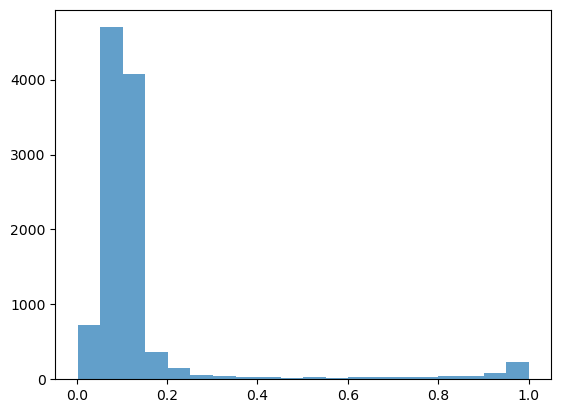

In [41]:
plt.hist(annotated_prob['cv_prob'], bins=20, alpha=0.7)

isCV -1
isCV 0
isCV 1


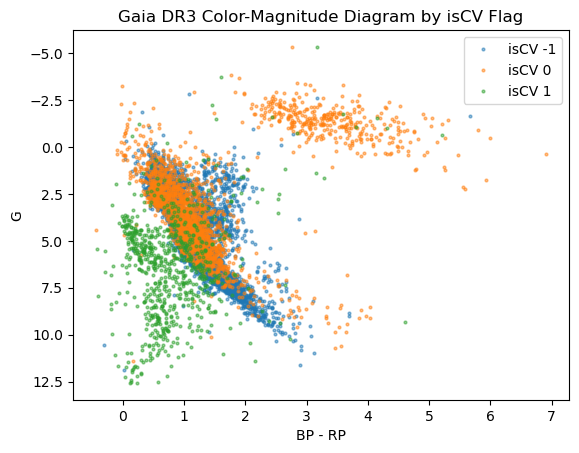

In [43]:
for eachIsCV in np.unique(annotated_prob['is_cv']):
    print("isCV", eachIsCV)
    isCV_data = annotated_prob[annotated_prob['is_cv'] == eachIsCV]
    plt.plot(isCV_data['BPmag'] - isCV_data['RPmag'],
             isCV_data['Gmag'] + 5 - 5 * np.log10(1000/isCV_data['Plx']),
             'o', label=f'isCV {eachIsCV}', alpha=0.5, markersize=2)
plt.gca().invert_yaxis()
plt.xlabel('BP - RP')
plt.ylabel('G')
plt.title('Gaia DR3 Color-Magnitude Diagram by isCV Flag')
plt.legend()

415


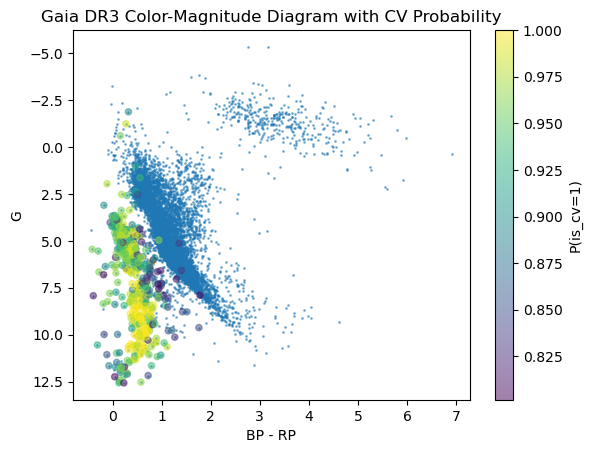

In [47]:
tmp = annotated_prob[annotated_prob['cv_prob'] > 0.8]
print(len(tmp))

plt.scatter(annotated_prob['BPmag'] - annotated_prob['RPmag'],
            annotated_prob['Gmag'] + 5 - 5 * np.log10(1000/annotated_prob['Plx']),
            s=1, alpha=0.5)
plt.scatter(tmp['BPmag'] - tmp['RPmag'],
            tmp['Gmag'] + 5 - 5 * np.log10(1000/tmp['Plx']),
            c=tmp['cv_prob'], cmap='viridis', s=20, alpha=0.5)
plt.colorbar(label='P(is_cv=1)')
plt.xlabel('BP - RP')
plt.ylabel('G')
plt.title('Gaia DR3 Color-Magnitude Diagram with CV Probability')
plt.gca().invert_yaxis()

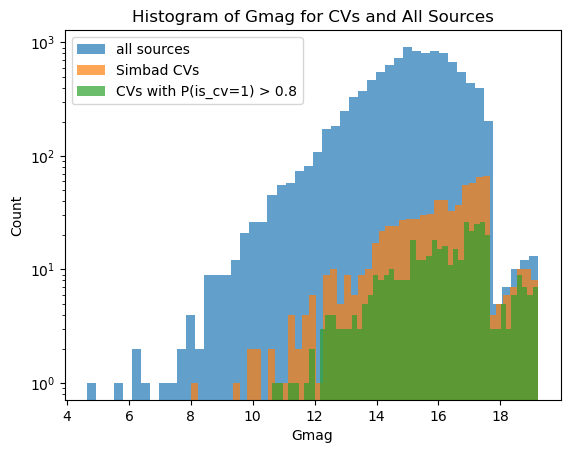

In [53]:
plt.hist(annotated_prob['Gmag'], bins=50, alpha=0.7,log=True,label='all sources')
plt.hist(simbad_cvs_gaia_all['Gmag'], bins=50, alpha=0.7,log=True,label='Simbad CVs')
plt.hist(tmp['Gmag'], bins=50, alpha=0.7,log=True, label='CVs with P(is_cv=1) > 0.8')
plt.xlabel('Gmag')
plt.ylabel('Count')
plt.title('Histogram of Gmag for CVs and All Sources')
plt.legend()



(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,
          1.,   0.,   0.,   0., 408.,   3.]),
 array([-434.7826087 , -425.81850015, -416.8543916 , -407.89028305,
        -398.9261745 , -389.96206595, -380.9979574 , -372.03384885,
        -363.0697403 , -354.10563175, -345.1415232 , -336.17741465,
        -327.2133061 , -318.24919755, -309.285089  , -300.32098045,
        -291.3568719 , -282.39276335, -273.4286548 , -264.46454625,
        -255.5004377 , -246.53632915, -237.5722206 , -228.60811205,
        -219.6440035 , -210.67989495, -201.7157864 , -192.75167785,
        -183.7875693 , -174.82346075, -165.8593522 , -156.89524365,
        -147.9311351 , -138.96702655, -130.002918  , -121.03880945,
        -112.0747009 , -103.11059235,  -94.146

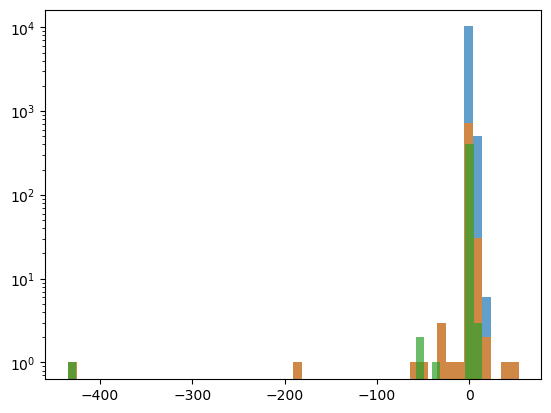

In [ ]:
plt.hist(1/annotated_prob['Plx'], bins=50, alpha=0.7,log=True,label='all sources')
plt.hist(1/simbad_cvs_gaia_all['Plx'], bins=50, alpha=0.7,log=True,label='Simbad CVs')
plt.hist(1/tmp['Plx'], bins=50, alpha=0.7,log=True,label='CVs with P(is_cv=1) > 0.8')
plt.xlim(0,100)


## Sky distribution



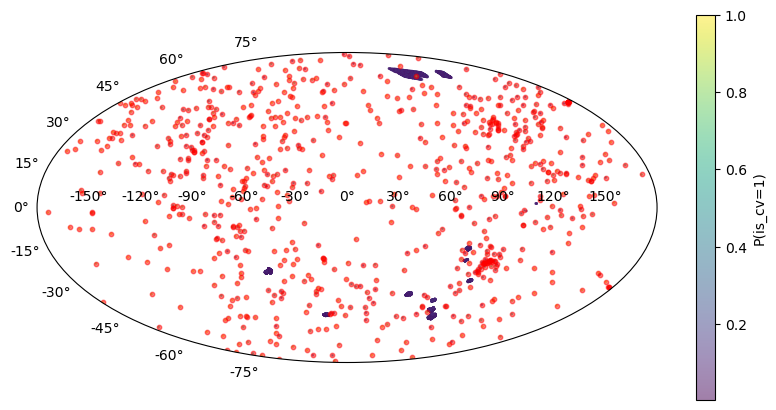

In [44]:
# aitoff projection
plt.figure(figsize=(10, 5))
plt.subplot(111, projection='aitoff')

ra = np.deg2rad(annotated_prob['ra'] - 180)  # Shift RA to center at 180 degrees
dec = np.deg2rad(annotated_prob['dec'] ) 
plt.scatter(ra, dec, s=1, alpha=0.5, c=annotated_prob['cv_prob'], cmap='viridis')
plt.colorbar(label='P(is_cv=1)')

ra = np.deg2rad(simbad_cvs_gaia_all['ra'] - 180)  # Shift RA to center at 180 degrees
dec = np.deg2rad(simbad_cvs_gaia_all['dec'] ) 
plt.scatter(ra, dec, s=10, alpha=0.5,c='red', label='Simbad CVs')



I should use this
https://arxiv.org/abs/2506.07097
as a reference for the distribution in the plane of the Milky Way